In [2]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data_dir = 'data/'
data_file = 'dataset_SCL.csv'

# use pathlib to create a path to the data file 
data_path = Path(data_dir + data_file)

In [4]:
df = pd.read_csv(data_path) 


/tmp/ipykernel_6118/3027768589.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [5]:
df.head()


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [6]:
df.isnull().sum().to_frame().T

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df[df.isnull().any(axis=1)]


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


In [8]:
ratio = df.nunique() / df.shape[0]
display(ratio.to_frame().T)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0.780752,0.010996,0.000015,0.000938,0.00044,0.920359,0.012697,0.000015,0.000924,0.000469,0.000455,0.000176,0.000029,0.000103,0.000029,0.000337,0.000015,0.000909


In [9]:
# since there is only one missing value we can drop the row 
df = df.dropna()

In [10]:
df.dtypes.to_frame().T


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,object,object,object,object,object


In [11]:
# conver the date columns to datetime (Fecha-I	 and Fecha-O) 
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])


In [12]:
df.dtypes.to_frame().T


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,datetime64[ns],object,object,object,object,datetime64[ns],object,object,object,object,int64,int64,int64,object,object,object,object,object


In [13]:
# create two new columns for the year and month  
df['year'] = df['Fecha-I'].dt.year
df['month'] = df['Fecha-I'].dt.month


## Univariate analysis 

In [113]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,year,month
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,2017,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,2017,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,2017,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,2017,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,2017,1


I'll start looking for patterns in the data that may help to create decide the data transformation steps.


In [19]:
## Create the barplot
#
base_color = '#3B3B3B'
#
#sns.countplot(x="month" ,data=df,
#            palette=[base_color])
#
#plt.title('Number of flights per month')
#plt.xlabel('Month')
#plt.show()


In [16]:
##### calculate the percentage of flights per month 
#
#flights_per_month_pct = (df
#.groupby('month')
#.size()
#.reset_index(name='counts')
#.assign(percentage = lambda x: x['counts'] / x['counts'].sum() * 100)
#)
#
#sns.barplot(x=flights_per_month_pct['month'], y=flights_per_month_pct['percentage'],
#            palette=[base_color])
#
## Add a title and x and y labels
#plt.title('Percentage of flights per month')
#plt.xlabel('Month')
#plt.ylabel('Percentage of flights')
#
#
#plt.axhline(y=flights_per_month_pct['percentage'].mean(), color='r', linestyle='dashed', linewidth=1)
#plt.text(x=3, y=8.4, s='Average', size=10)
#
## Show the plot
#plt.show()

In [79]:
# From the above plot we can see that the number of flights is not evenly distributed over the months. 
# It seems to be some seasonal pattern, since the months with the highest number of flights are the consecutive (October, November, December and January) this could be due to the summer and vacation season in Chile 


In [61]:
def make_bar_plot(df, target, title, key_map={}):
    """
    This function creates a bar plot showing the percentage of values in a target column of a DataFrame.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to plot.
        target (str): The name of the column to use as the target of the plot.
        title (str): The title of the plot.
        key_map (dict, optional): A mapping of values in the target column to their desired order in the plot. Default is an empty dictionary.
    
    Returns:
        None
    """
    
    # Calculate the percentage of values in the target column
    df_pct = (df
    .groupby(target)
    .size()
    .reset_index(name='counts')
    .assign(percentage = lambda x: x['counts'] / x['counts'].sum() * 100)
    .sort_values(by=target, key=lambda x: x.map(key_map))
    )
    
    # Create the bar plot
    sns.barplot(x=df_pct[target], y=df_pct['percentage'],
                palette=[base_color])

    # Add a title and x-label to the plot
    plt.title(title)
    plt.xlabel(target)
    
    # Add a horizontal reference line and label
    reference = df_pct['percentage'].mean()
    plt.axhline(y=reference ,color='r', linestyle='dashed', linewidth=1)
    #plt.text(x=3, y=reference+0.1, s='Average', size=10)
    
    # Show the plot
    plt.show()

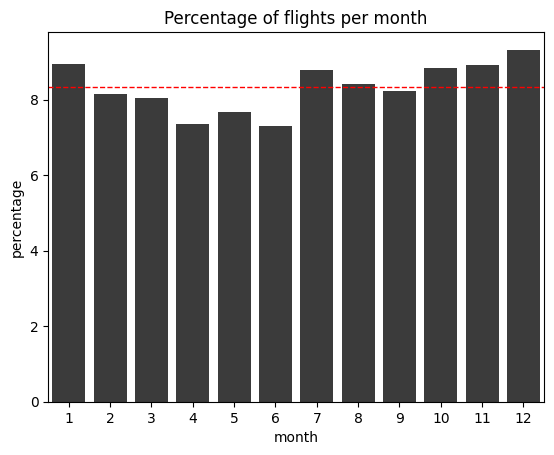

In [20]:
make_bar_plot(df,'month','Percentage of flights per month')

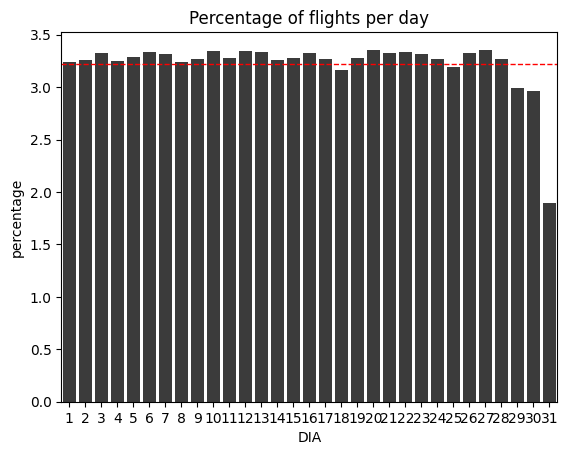

In [21]:
make_bar_plot(df,'DIA','Percentage of flights per day')

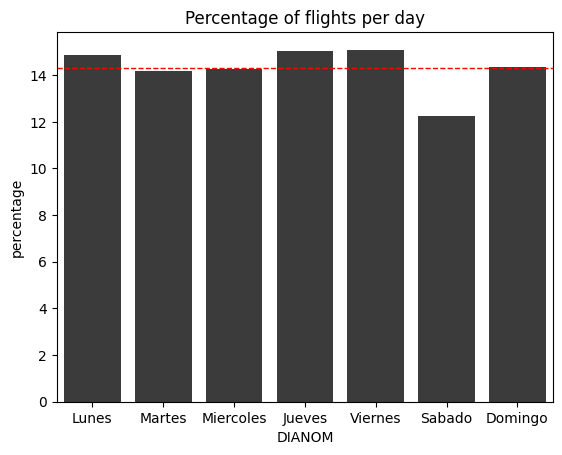

In [22]:
day_map = {'Lunes':1, 'Martes':2, 'Miercoles':3, 'Jueves':4, 'Viernes':5, 'Sabado':6, 'Domingo':7}

make_bar_plot(df,'DIANOM','Percentage of flights per day',day_map)

In [33]:
# Comparing the Scheduled flights and the actual flights there are 116 additional flights numbers, 
# this could be related with delays if we linked to the airline data   


print ("'Vlo-I ' has {} unique values".format(df['Vlo-I'].nunique()))
display (df['Vlo-I'].value_counts(dropna=False).to_frame().T)

print ("'Vlo-O ' has {} unique values".format(df['Vlo-O'].nunique()))
display (df['Vlo-O'].value_counts(dropna=False).to_frame().T)

'Vlo-I ' has 750 unique values


,174,11,116,150,162,164,704,118,172,170,...,1400,2488,1155,1113,1105,1158,368,9955,9701,1218
Vlo-I,686,645,608,557,553,550,515,508,498,495,...,1,1,1,1,1,1,1,1,1,1


'Vlo-O ' has 866 unique values


,174,11,116,150,704,162,164,118,172,170,...,1052,1050,60,8541,9622,356,1148,846A,4950,180.0
Vlo-O,649,646,608,517,514,512,508,507,466,452,...,1,1,1,1,1,1,1,1,1,1


In [38]:
# The variables 'Vlo-I' and 'Vlo-O' are constant, hence we will not use them in the rest of the analysis 

display (df['Ori-I'].value_counts(dropna=False).to_frame().T)

display (df['Ori-O'].value_counts(dropna=False).to_frame().T)

,SCEL
Ori-I,68205


,SCEL
Ori-O,68205


In [42]:
# At first glance we can see there are a few differences between Des-I and Des-O, 
# this could be relevant for stimated delays 

display (df['Des-I'].value_counts(dropna=False).to_frame().T)

display (df['Des-O'].value_counts(dropna=False).to_frame().T)

,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,...,SULS,SBCT,SAZS,SLCB,EGYP,SBFI,SPSO,SEQU,SEQM,SARI
Des-I,5787,5269,5145,4357,3995,3747,3570,3240,3094,2583,...,6,3,2,1,1,1,1,1,1,1


,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,...,SULS,SAWH,SBCT,SBFI,SAZS,SEQM,KIAD,SPSO,EGYP,SLCB
Des-O,5786,5269,5146,4357,3993,3747,3569,3241,3094,2589,...,6,6,3,2,2,2,1,1,1,1


In [47]:
# We can see that there are significant discrepancies between Emp-I and Emp-O

display (df['Emp-I'].value_counts(dropna=False).to_frame().T    )

display (df['Emp-O'].value_counts(dropna=False).to_frame().T)

,LAN,SKU,TAM,ARG,CMP,LAW,AVA,JAT,GLO,AAL,...,BAW,QFU,JMR,LRC,AUT,PUE,LXP,LPE,DSM,LNE
Emp-I,37611,14298,3049,1949,1850,1573,1152,1095,806,757,...,205,195,100,92,74,49,9,4,2,1


,LAN,LXP,SKU,TAM,ARG,CMP,JMR,LPE,JAT,AVA,...,AZA,KLM,LAP,BAW,QFA,AUT,PUE,56R,48O,TPU
Emp-O,20988,14558,14298,3046,1946,1850,1647,1214,1095,885,...,259,251,219,205,195,77,49,16,10,2


In [52]:
# For Fecha-I and Fecha-O we can see that Fecha-O has more unique values, which is expected since it is expected 
# that the programed flighs have more round times, e.g. 12:00 vs a delayed flight that could be 12:03 


display (df['Fecha-I'].value_counts(dropna=False).to_frame().T)
display (df['Fecha-O'].value_counts(dropna=False).to_frame().T)

,2017-07-28 13:30:00,2017-03-19 18:00:00,2017-03-26 18:00:00,2017-12-16 13:35:00,2017-02-15 13:35:00,2017-04-02 18:00:00,2017-09-06 12:00:00,2017-07-29 06:45:00,2017-08-01 05:00:00,2017-06-27 05:00:00,...,2017-06-05 15:16:00,2017-06-27 06:53:00,2017-06-28 06:53:00,2017-06-29 06:53:00,2017-06-30 06:53:00,2017-06-01 15:16:00,2017-06-02 15:16:00,2017-06-03 15:16:00,2017-06-04 15:16:00,2017-12-31 14:55:00
Fecha-I,6,6,6,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1


,2017-05-19 07:01:00,2017-11-05 14:51:00,2017-10-25 07:37:00,2017-03-08 13:34:00,2017-09-07 20:10:00,2017-02-12 09:12:00,2017-05-28 08:12:00,2017-05-23 08:50:00,2017-02-15 09:20:00,2017-12-01 13:49:00,...,2017-05-30 11:44:00,2017-05-31 11:04:00,2017-05-01 17:10:00,2017-05-02 17:03:00,2017-05-03 17:03:00,2017-05-04 15:48:00,2017-05-05 17:02:00,2017-05-07 17:03:00,2017-05-08 17:06:00,2017-12-31 15:04:00
Fecha-O,5,5,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot: >

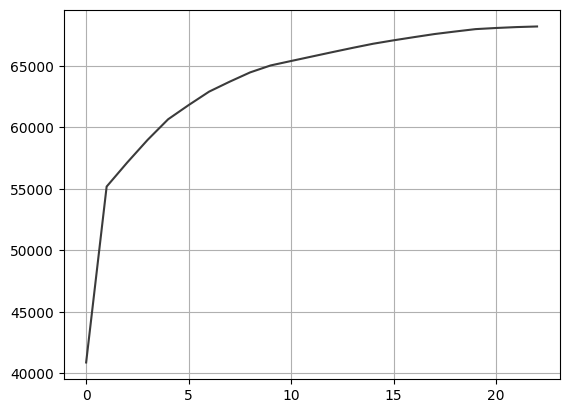

In [54]:
df['OPERA'].value_counts(dropna=False).sort_values(ascending=False).to_frame().T

df.groupby('OPERA').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color=base_color,grid=True)


In [180]:
# For the origin airport we can see that all the flights are from Santiago (SCL)
df.groupby('SIGLAORI').size().reset_index(name='counts')


(df
.groupby('SIGLADES')
.size()
.reset_index(name='counts')
.sort_values(by='counts', ascending=False)
)


,SIGLAORI,counts
0,Santiago,68205


,SIGLADES,counts
8,Buenos Aires,6335
0,Antofagasta,5786
28,Lima,5269
9,Calama,5146
42,Puerto Montt,4357
...,...,...
12,Cataratas Iguacu,2
41,"Pisco, Peru",1
44,Puerto Stanley,1
15,Cochabamba,1


array([[<AxesSubplot: title={'center': 'counts'}>]], dtype=object)

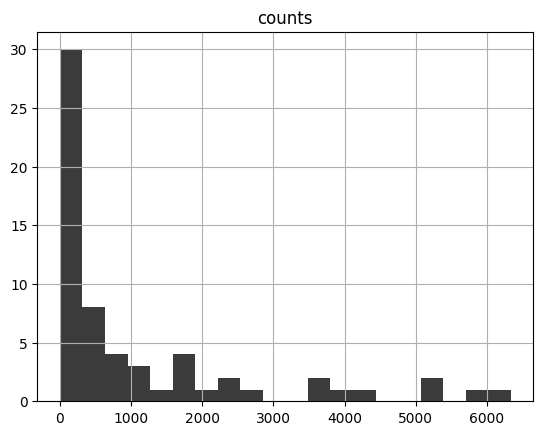

In [182]:
df.groupby('SIGLADES').size().reset_index(name='counts').hist(color=base_color,bins=20)

<AxesSubplot: >

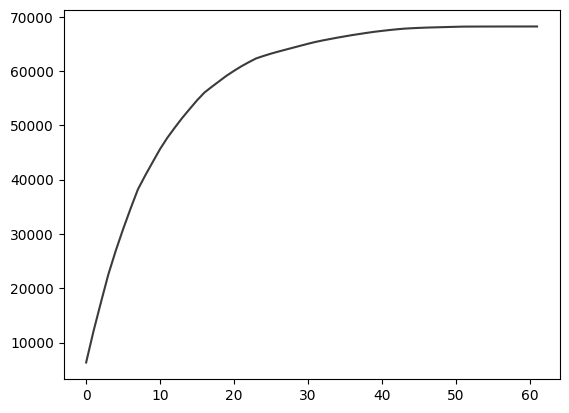

In [183]:
# from the below plot we can see that the top 10 destinations account for about 60% of the total flights

df.groupby('SIGLADES').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color=base_color)

# In relation to the target variable it can be expected that on average the delay on the frequent flights is lower than the delay on the less frequent flights. 

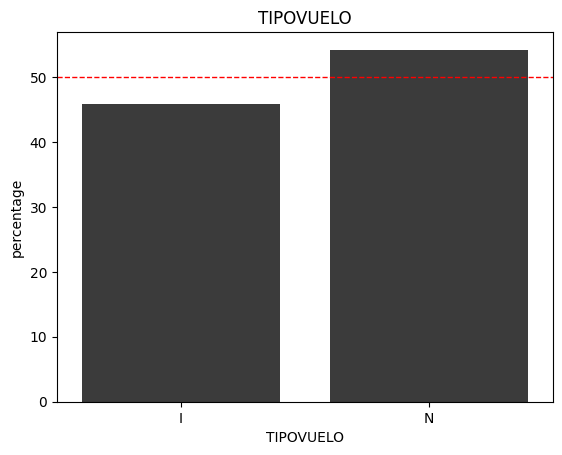

In [59]:
# Regarding the type of flight we can see that the majority of the flights are domestic flights (Nacional)
# but the percentage of international flights is close to half of the domestic flights.
df['TIPOVUELO'].value_counts(dropna=False).to_frame().T

make_bar_plot(df, 'TIPOVUELO', 'TIPOVUELO', key_map={})


,Grupo LATAM,Sky Airline,Aerolineas Argentinas,Copa Air,Latin American Wings,Avianca,JetSmart SPA,Gol Trans,American Airlines,Air Canada,...,Aeromexico,United Airlines,Oceanair Linhas Aereas,Alitalia,K.L.M.,British Airways,Qantas Airways,Lacsa,Austral,Plus Ultra Lineas Aereas
OPERA,40892,14298,1949,1850,1673,1152,1095,806,757,565,...,351,335,279,259,251,205,195,92,74,49


<AxesSubplot: >

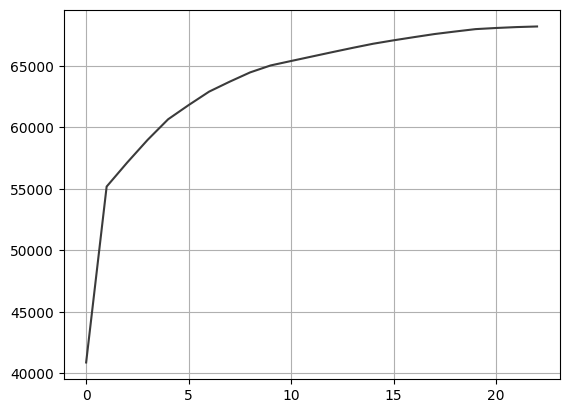